In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

In [50]:
DATA_PATH = "/home/stefan/Documents/Workspace/Python/ML/Hackathon/eco-forecast/data"
FILE_NAME = "raw_data.csv"

REGION_CODES = [name for name in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, name))]

FILE_PATH = f'{DATA_PATH}/{FILE_NAME}'

#### Load data and inspect it

In [22]:
df = pd.read_csv(FILE_PATH)

In [23]:
df.head()

,Unnamed: 0,StartTime,green_energy_SE,SE_Load,green_energy_DE,DE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_SP,SP_Load,green_energy_NE,NE_Load,green_energy_PO,PO_Load,UK_Load,green_energy_DK,DK_Load
0,0,2021-12-31 23:00:00,11061.0,15331.0,151608.0,168784.0,1208.0,17016.0,5777.000000,21121.0,11512.0,20827.0,15788.0,41304.0,4734.0,14438.0,1354.0,3821.0,3314.0
1,1,2022-01-01 00:00:00,11108.0,15331.0,148520.0,165125.0,1441.0,16457.0,5703.666667,19756.0,11092.0,19530.0,14335.0,40706.0,4584.0,13935.0,1244.0,3774.0,3218.0
2,2,2022-01-01 01:00:00,11037.0,15270.0,141730.0,160415.0,1592.0,15426.0,5627.333333,18685.0,11406.0,18383.0,12747.0,39465.0,4529.0,13579.0,1131.0,3478.0,3126.0
3,3,2022-01-01 02:00:00,10510.0,15150.0,135947.0,158035.0,1624.0,14781.0,5780.000000,18124.0,11621.0,17680.0,12919.0,38923.0,4661.0,13397.0,1091.0,3212.0,3080.0
4,4,2022-01-01 03:00:00,10771.0,15387.0,130309.0,157016.0,1352.0,14630.0,5545.666667,18400.0,11513.0,17396.0,12901.0,38211.0,4652.0,13364.0,969.0,3021.0,3044.0


In [24]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   StartTime        98 non-null     object 
 1   green_energy_SE  98 non-null     float64
 2   SE_Load          98 non-null     float64
 3   green_energy_DE  97 non-null     float64
 4   DE_Load          97 non-null     float64
 5   green_energy_HU  97 non-null     float64
 6   HU_Load          97 non-null     float64
 7   green_energy_IT  98 non-null     float64
 8   IT_Load          98 non-null     float64
 9   green_energy_SP  98 non-null     float64
 10  SP_Load          98 non-null     float64
 11  green_energy_NE  97 non-null     float64
 12  NE_Load          97 non-null     float64
 13  green_energy_PO  98 non-null     float64
 14  PO_Load          98 non-null     float64
 15  UK_Load          97 non-null     float64
 16  green_energy_DK  98 non-null     float64
 17  DK_Load          9

Transforming feature 'StartTime' from string to datetime that we can use later if needed

In [26]:
df['StartTime'] = pd.to_datetime(df['StartTime'])

In [27]:
df['StartTime'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 98 entries, 0 to 97
Series name: StartTime
Non-Null Count  Dtype         
--------------  -----         
98 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 912.0 bytes


Checking if there are any missing values

In [28]:
print(f"Percentage of data missing: {df.isna().sum().sum() / df.shape[0]}%")

Percentage of data missing: 0.07142857142857142%


Checking which features are missing the data

In [29]:
print(df.isna().sum())

StartTime          0
green_energy_SE    0
SE_Load            0
green_energy_DE    1
DE_Load            1
green_energy_HU    1
HU_Load            1
green_energy_IT    0
IT_Load            0
green_energy_SP    0
SP_Load            0
green_energy_NE    1
NE_Load            1
green_energy_PO    0
PO_Load            0
UK_Load            1
green_energy_DK    0
DK_Load            0
dtype: int64


Due to already dealing with majority of missing data during data_ingestion, we've only got a few missing values (most likely appearing after merging the data)

We'll just impute the missing data with mean values of preceeding and following samples relative to the missing data point

In [30]:
df.interpolate(method='linear', limit_direction='both', inplace=True)

We could use .describe() to learn more about our data by checking it mean, std, min, max etc. values

We can see that the green energy values differ by quite a bit from region to region which could imply that we'd want to normalize our data prior to feeding it to the model.

There are few regions where there's quite a difference between the minimum and maximum values, we'll have to further analyse those samples.

In [31]:
df.describe()

,StartTime,green_energy_SE,SE_Load,green_energy_DE,DE_Load,green_energy_HU,HU_Load,green_energy_IT,IT_Load,green_energy_SP,SP_Load,green_energy_NE,NE_Load,green_energy_PO,PO_Load,UK_Load,green_energy_DK,DK_Load
count,98,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,2022-01-02 23:30:00,12342.841837,17944.122449,146998.867347,215185.571429,1635.280612,19407.071429,8137.622449,27033.214286,14195.025510,24820.091837,14926.755102,48921.540816,4274.397959,18453.714286,1604.591837,4125.020408,4163.397959
min,2021-12-31 23:00:00,7898.000000,14706.000000,97098.000000,154275.000000,713.901639,14142.000000,4750.200000,17737.000000,7067.000000,17396.000000,6255.000000,38146.000000,1429.812500,13267.000000,860.000000,1770.000000,3044.000000
25%,2022-01-01 23:15:00,11448.250000,16456.500000,120284.808333,182012.250000,981.750000,16677.000000,6652.392857,21399.250000,10762.875000,21060.000000,12728.250000,42344.000000,3318.500000,15469.000000,1152.250000,3165.500000,3498.000000
50%,2022-01-02 23:30:00,12668.000000,17745.000000,132715.016667,208384.000000,1405.000000,18961.500000,8177.666667,25317.000000,14489.000000,24318.500000,16378.500000,47861.500000,4405.000000,17752.000000,1620.000000,3909.000000,4038.000000
75%,2022-01-03 23:45:00,13495.750000,19635.750000,181347.075000,254376.750000,1837.250000,22926.000000,9529.625000,34012.500000,17737.000000,29247.250000,17748.500000,55556.250000,5109.350000,22672.750000,1976.000000,5066.500000,4876.750000
max,2022-01-05 00:00:00,14840.000000,22098.000000,219611.000000,281315.000000,4398.000000,24804.000000,12982.000000,38809.000000,21987.000000,32753.000000,18938.000000,65179.000000,7032.000000,24402.000000,2790.000000,6659.000000,5641.000000
std,NaN,1550.412948,2028.110467,34839.614459,41030.900657,871.429761,3216.922257,2012.884461,6560.787431,4192.350535,4678.610612,3598.214798,7595.218208,1333.948321,3664.176506,503.186126,1265.775456,751.026895


Adding columns for day, hour, month so we can use them for plotting

In [32]:
df['day'] = df['StartTime'].dt.day
df['month'] = df['StartTime'].dt.month
df['hour'] = df['StartTime'].dt.hour

#### Plots

Plotting a correlation matrix to check if there's any correlation between the day or month with green energy values or load values

In [33]:
corrMatrix = df.corr().round(2)

There seems to be some relatively mid-high correlation between green energy/load values with hourly information, further on we'll check this using different plots

<Axes: >

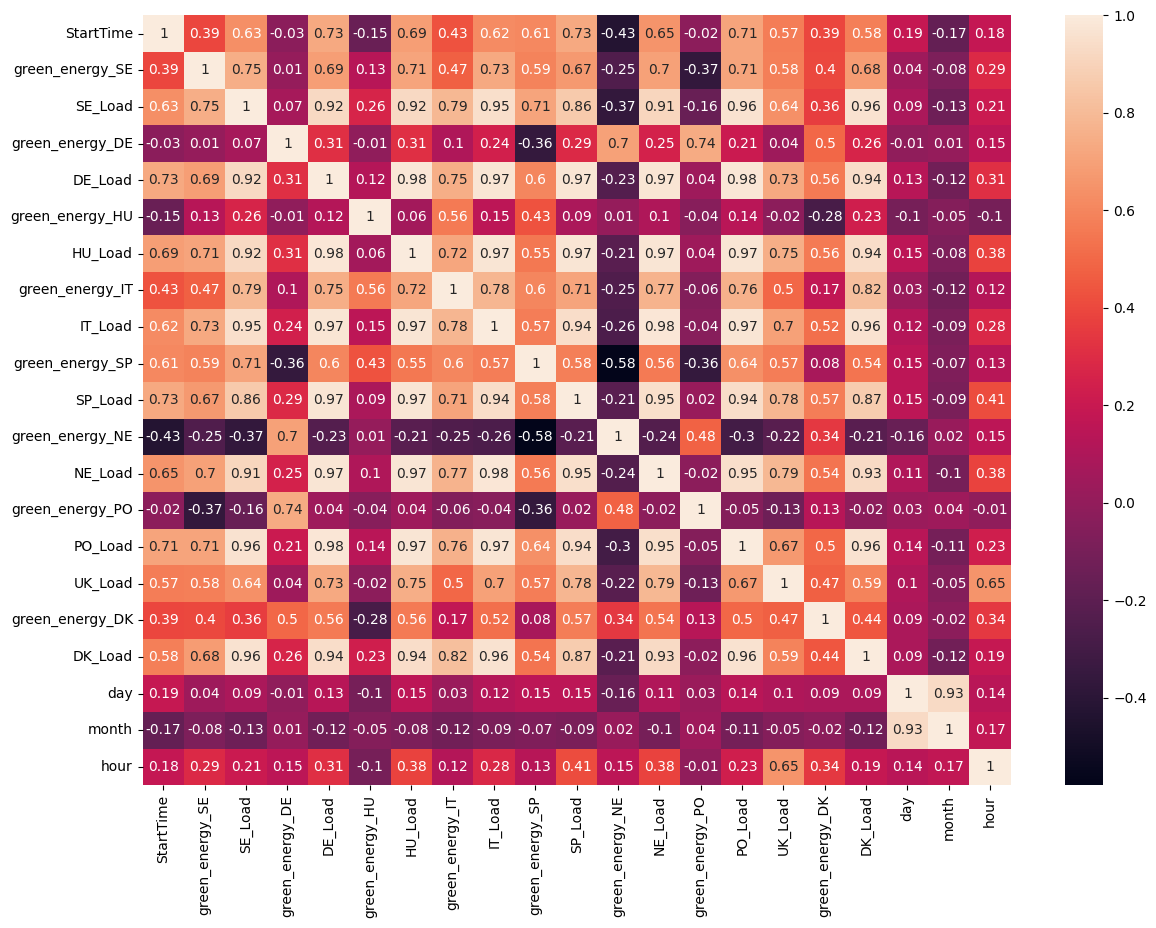

In [37]:
plt.figure(figsize=(14, 10))
sb.heatmap(corrMatrix, annot=True)

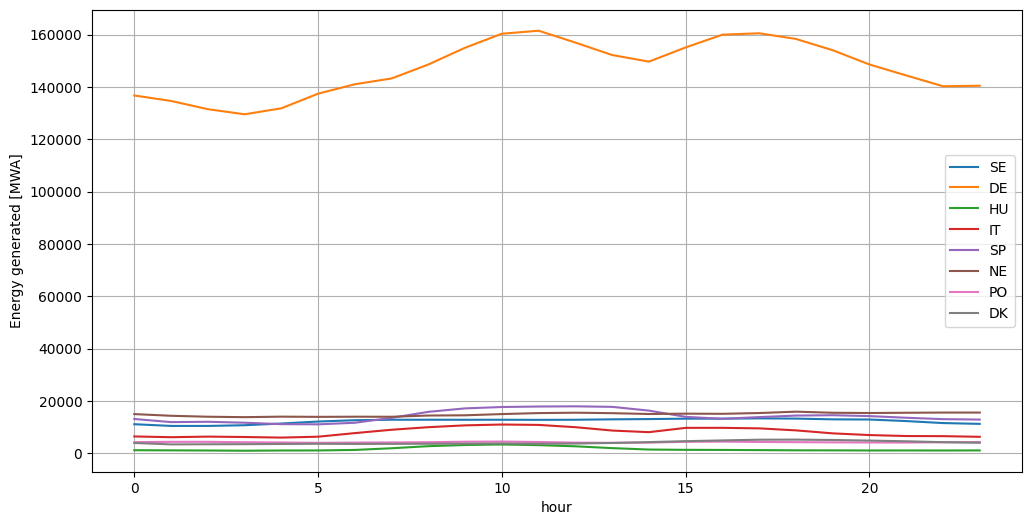

In [56]:
plt.figure(figsize=(12, 6))
for reg in REGION_CODES:
    if f'green_energy_{reg}' not in list(df.columns):
        continue
    df.groupby(['hour'])[f'green_energy_{reg}'].mean().plot(label=reg, legend=True)
    # df.groupby(['hour'])['green_energy_SE'].mean().plot(label='SE', legend=True)
    # df.groupby(['hour'])['green_energy_DE'].mean().plot(label='DE', legend=True)
    # df.groupby(['hour'])['green_energy_HU'].mean().plot(label='HU', legend=True)
plt.grid()
plt.xlabel('hour')
plt.ylabel('Energy generated [MWA]')
plt.show()

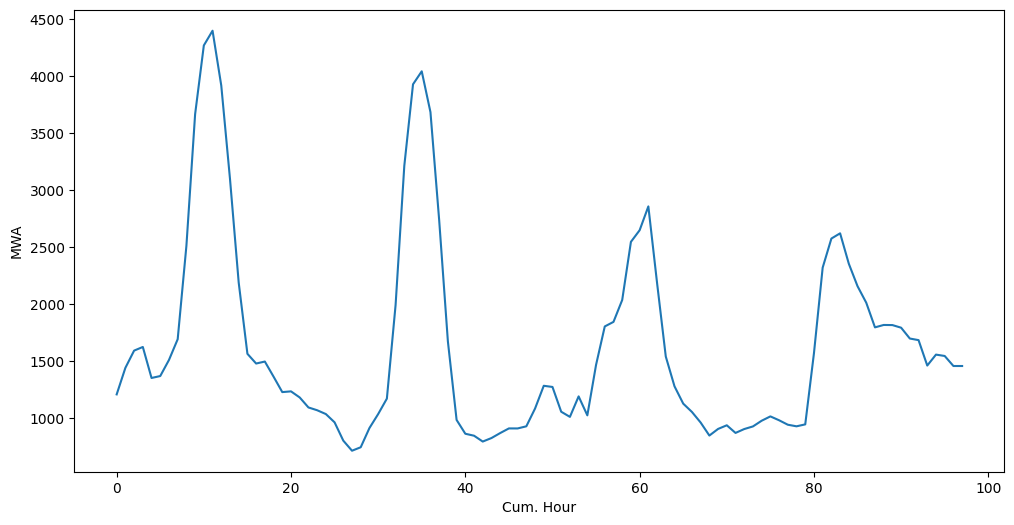

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(df['green_energy_HU'])
plt.xlabel('Cum. Hour')
plt.ylabel('MWA')
plt.show()

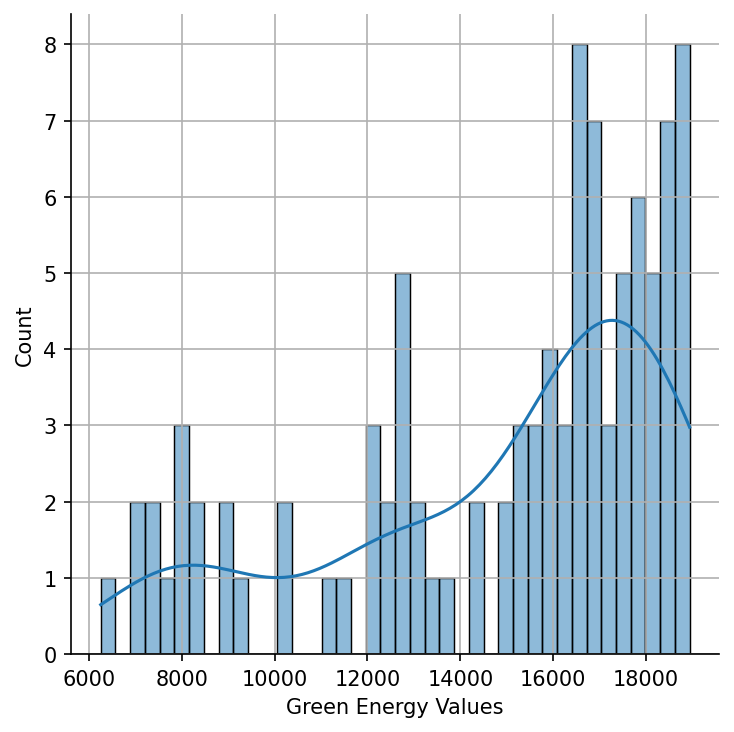

In [64]:
p = sb.displot(df['green_energy_NE'], bins=40, kde=True, rug=False)
plt.grid()
plt.xlabel(xlabel='Green Energy Values')
p.fig.set_dpi(150)
plt.show()
